## Predicting Air Quality Index (AQI) Using Machine Learning and Deep Learning Models
*Students* Andrea Thomas, Joseph Edwards, Jinyuan He

# Introduction

Air pollution has become one of the most significant environmental and public health challenges in modern cities. Poor air quality is closely linked to respiratory illness, reduced life expectancy, productivity losses, and increased healthcare burden. For governments, environmental agencies, and businesses, accurate forecasting of air quality is essential for early warnings, public protection, and operational decision-making.

In this project, we focus on predicting the Air Quality Index (AQI) using the **Taiwan Air Quality Dataset (2016–2024)**, an hourly dataset published on Kaggle. Taiwan provides an excellent case study due to its dense urban centers, complex topography, and highly variable meteorological patterns influenced by monsoon seasons, typhoons, long-range dust transport, and industrial activity. These unique characteristics make AQI prediction both scientifically interesting and practically important.

The goal of this project is to build a complete machine learning pipeline to forecast hourly AQI values based on historical pollutant concentrations and weather conditions. We construct models from three categories:

- **Baseline Model:** Linear Regression  
- **Tree-Based Models:** Random Forest and XGBoost  
- **Deep Learning Sequence Models:** Feedforward Neural Network (FNN) and Long Short-Term Memory (LSTM)

By comparing these approaches, we aim to understand:
1. Which model family performs best for Taiwan's AQI patterns  
2. Which pollutant and meteorological variables contribute most to prediction accuracy  
3. How temporal dependencies (lag features and sequences) influence forecasting quality  

This notebook includes end-to-end steps:
- Data loading and exploratory analysis  
- Feature engineering (time features, lag features, rolling windows)  
- Model development across ML and DL techniques  
- Evaluation with MAE, RMSE, and R²  
- Visualization of predictions and feature importances  

Ultimately, this project provides a practical and data-driven approach to AQI forecasting tailored to Taiwan's environmental context, demonstrating how machine learning and deep learning can support smarter air-quality monitoring and early-warning systems.



# 1. Data Cleaning & Exploratory Data Analysis

In [1]:
# install kagglehub if needs
#!pip install kagglehub[pandas-datasets]
import kagglehub
import pandas as pd
import numpy as np

google_drive_path = '/content/drive/MyDrive/USD/2025 Fall/AAI-501/Final Project/datasets/'

### 1.1 Data Loading

In [1]:
# Download the dataset (KaggleHub returns the local directory path)
local_dir = kagglehub.dataset_download("taweilo/taiwan-air-quality-data-20162024")

print("Downloaded to:", local_dir)

100%|██████████| 172M/172M [00:02<00:00, 65.7MB/s]

Extracting files...


Downloaded to: /root/.cache/kagglehub/datasets/taweilo/taiwan-air-quality-data-20162024/versions/1


In [2]:
df = pd.read_csv(f"{local_dir}/air_quality.csv")
df.head()

/tmp/ipython-input-241818074.py:1: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,15,16,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{local_dir}/air_quality.csv")


,date,sitename,county,aqi,pollutant,status,so2,co,o3,o3_8hr,...,windspeed,winddirec,unit,co_8hr,pm2.5_avg,pm10_avg,so2_avg,longitude,latitude,siteid
0,2024-08-31 23:00,Hukou,Hsinchu County,62.0,PM2.5,Moderate,0.9,0.17,35.0,40.2,...,2.3,225,NaN,0.2,20.1,26.0,1.0,121.038869,24.900097,22.0
1,2024-08-31 23:00,Zhongming,Taichung City,50.0,NaN,Good,1.6,0.32,27.9,35.1,...,1.1,184,NaN,0.2,15.3,23.0,1.0,120.641092,24.151958,31.0
2,2024-08-31 23:00,Zhudong,Hsinchu County,45.0,NaN,Good,0.4,0.17,25.1,40.6,...,0.4,210,NaN,0.2,13.8,24.0,0.0,121.088955,24.740914,23.0
3,2024-08-31 23:00,Hsinchu,Hsinchu City,42.0,NaN,Good,0.8,0.2,30.0,35.9,...,1.9,239,NaN,0.2,13.0,26.0,1.0,120.972368,24.805636,24.0
4,2024-08-31 23:00,Toufen,Miaoli County,50.0,NaN,Good,1.0,0.16,33.5,35.9,...,1.8,259,NaN,0.1,15.3,28.0,1.0,120.898693,24.696907,25.0


### 1.2 Data type Conversion

In [3]:
# Convert data type
df['date'] = pd.to_datetime(df['date'], errors='coerce')
for col in df.columns:
    if col not in ['date', 'sitename', 'county', 'pollutant', 'status', 'unit']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("Data types after numeric conversion:")
df.info()

Data types after numeric conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5882208 entries, 0 to 5882207
Data columns (total 25 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       datetime64[ns]
 1   sitename   object        
 2   county     object        
 3   aqi        float64       
 4   pollutant  object        
 5   status     object        
 6   so2        float64       
 7   co         float64       
 8   o3         float64       
 9   o3_8hr     float64       
 10  pm10       float64       
 11  pm2.5      float64       
 12  no2        float64       
 13  nox        float64       
 14  no         float64       
 15  windspeed  float64       
 16  winddirec  float64       
 17  unit       float64       
 18  co_8hr     float64       
 19  pm2.5_avg  float64       
 20  pm10_avg   float64       
 21  so2_avg    float64       
 22  longitude  float64       
 23  latitude   float64       
 24  siteid     float64       
dtypes: datet

### 1.3 Missing values handling

In [4]:
processed_df = df.copy()

initial_count = len(processed_df)

# Drop the siteid and date is missing
processed_df = processed_df.dropna(subset=['siteid', 'date'])

# Drop unuseful column
processed_df = processed_df.drop(columns=['unit', 'pollutant', 'unit', 'co_8hr', 'pm2.5_avg', 'pm10_avg', 'so2_avg'])

processed_df = processed_df.dropna(subset=['siteid'])
print(f"Drop missing siteid from: {len(processed_df):,} rows (dropped {initial_count - len(processed_df):,} rows)")

# fill location with median value
if 'siteid' in processed_df.columns and 'latitude' in processed_df.columns:
    # calculate median
    station_coords = processed_df.groupby('siteid')[['latitude', 'longitude']].median()

    # fill up the missing values
    for siteid in processed_df['siteid'].unique():
        mask = (processed_df['siteid'] == siteid) & (processed_df['latitude'].isna())
        if mask.any() and siteid in station_coords.index:
            processed_df.loc[mask, 'latitude'] = station_coords.loc[siteid, 'latitude']
            processed_df.loc[mask, 'longitude'] = station_coords.loc[siteid, 'longitude']

    print(f"After filled up，latitude still missing: {processed_df['latitude'].isna().sum()}")

# Remove duplicated rows for each site and timestamp
processed_df = processed_df.drop_duplicates(subset=['siteid', 'date'], keep='first')

# sort data by siteid and date
processed_df = processed_df.sort_values(['siteid', 'date'])

processed_df = processed_df.ffill().bfill()

# check sum of still missing data
print(f"Still missing data: {processed_df.isna().sum()}")

Drop missing siteid from: 4,102,654 rows (dropped 1,779,554 rows)
After filled up，latitude still missing: 0
Still missing data: date         0
sitename     0
county       0
aqi          0
status       0
so2          0
co           0
o3           0
o3_8hr       0
pm10         0
pm2.5        0
no2          0
nox          0
no           0
windspeed    0
winddirec    0
longitude    0
latitude     0
siteid       0
dtype: int64


### 1.4 Rebuild Time Series

Real-world AQI datasets often contain missing hours, long gaps, duplicated timestamps, or very short operating periods. These issues make the data unsuitable for time-series models like LSTM, which require consistent and evenly spaced sequences.

To ensure reliable forecasting, we apply two key preprocessing steps:

*   **Filter Out High-Quality Stations**
*   **Rebuild a Continuous Hourly Time Series**

In [5]:
min_rows = 40000
max_missing_ratio = 0.3
max_gap = 72

# remove duplicated timestamps
processed_df = processed_df.drop_duplicates(subset=['siteid', 'date'], keep='first')

# Count rows per site
site_counts = processed_df['siteid'].value_counts()

# First filter: sites with enough rows
sites_after_count = site_counts[site_counts >= min_rows].index.tolist()
print(f"Sites after row-count filtering: {len(sites_after_count)}")

# Missing ratio function
def missing_ratio(df, siteid):
    temp = df[df['siteid'] == siteid].copy()
    temp = temp.sort_values('date')
    full_range = pd.date_range(temp['date'].min(), temp['date'].max(), freq='h')
    return 1 - len(temp) / len(full_range)

# Filter by missing ratio
sites_after_ratio = []
for s in sites_after_count:
    ratio = missing_ratio(processed_df, s)
    if ratio <= max_missing_ratio:
        sites_after_ratio.append(s)

print(f"Sites after missing-ratio filtering: {len(sites_after_ratio)}")

# Function to get longest continuous missing gap
def longest_missing_hours(df, siteid):
    temp = df[df['siteid'] == siteid].copy(deep=True)
    temp = temp.sort_values('date')
    temp = temp.set_index('date')

    # Build full hourly timeline
    full_range = pd.date_range(start=temp.index.min(), end=temp.index.max(), freq='h')

    # Reindex is safe, but wrap .copy() to avoid view issues
    temp = temp.reindex(full_range).copy(deep=True)

    # Missing rows (force copy)
    missing = temp[temp.isna().any(axis=1)].copy(deep=True)

    if missing.empty:
        return 0

    missing.loc[:, 'gap'] = (
        missing.index.to_series().diff() > pd.Timedelta(hours=1)
    )

    missing.loc[:, 'group'] = missing.loc[:, 'gap'].cumsum()

    gap_sizes = missing.groupby('group').size()

    return int(gap_sizes.max())

# Filter by longest missing gap
final_good_sites = []
for s in sites_after_ratio:
    max_missing = longest_missing_hours(processed_df, s)
    if max_missing <= max_gap:
        final_good_sites.append(s)

print(f"Good sites count: {len(final_good_sites)}")
print("Final good sites:", final_good_sites)

# total data length of good site
processed_df = processed_df[processed_df['siteid'].isin(final_good_sites)]
processed_df.shape

Sites after row-count filtering: 80
Sites after missing-ratio filtering: 80
Good sites count: 74
Final good sites: [27.0, 11.0, 35.0, 25.0, 4.0, 1.0, 6.0, 7.0, 8.0, 2.0, 9.0, 10.0, 12.0, 13.0, 14.0, 16.0, 17.0, 3.0, 33.0, 18.0, 20.0, 19.0, 22.0, 23.0, 24.0, 21.0, 32.0, 26.0, 28.0, 30.0, 38.0, 39.0, 34.0, 5.0, 75.0, 72.0, 68.0, 84.0, 40.0, 41.0, 43.0, 42.0, 47.0, 48.0, 44.0, 45.0, 62.0, 63.0, 64.0, 66.0, 36.0, 65.0, 69.0, 31.0, 49.0, 15.0, 67.0, 70.0, 57.0, 71.0, 51.0, 52.0, 58.0, 61.0, 59.0, 54.0, 60.0, 29.0, 37.0, 46.0, 78.0, 83.0, 77.0, 80.0]


(3302552, 19)

In [6]:
# rebuild hourly timeline + fill values for ALL good sites
from tqdm import tqdm

def fill_missing_values(df, numeric_cols):
    """
    Apply ffill, bfill, and time-based interpolate
    to all numeric columns of a single site's DataFrame.
    """
    # Step 1: ffill + bfill
    df = df.ffill().bfill()

    # Step 2: time interpolation for smooth transitions
    for col in numeric_cols:
        df[col] = df[col].interpolate(method='time')

    return df

def rebuild_site_timeseries(df, siteid, numeric_cols):
    """
    Rebuild continuous hourly time series for a site,
    fill missing values across ALL numeric columns.
    """
    temp = df[df['siteid'] == siteid].copy(deep=True)

    # ensure datetime
    temp['date'] = pd.to_datetime(temp['date'])
    temp = temp.drop_duplicates(subset=['date'], keep='first')
    temp = temp.sort_values('date').set_index('date')

    # full hourly timeline
    full_range = pd.date_range(start=temp.index.min(), end=temp.index.max(), freq='h')

    # reindex then deep copy
    temp = temp.reindex(full_range).copy(deep=True)

    # fill missing values
    temp = fill_missing_values(temp, numeric_cols)

    # add siteid as a column again
    temp['siteid'] = siteid

    return temp


# detect numeric columns automatically
numeric_cols = processed_df.select_dtypes(include='number').columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['siteid']]  # siteid shouldn't be interpolated

print("Numeric columns used for interpolation:", numeric_cols)

# Process all good sites
cleaned_sites = []

for site in tqdm(final_good_sites):
    clean_df = rebuild_site_timeseries(processed_df, site, numeric_cols)
    cleaned_sites.append(clean_df)

# Combine all sites back into one DataFrame
cleaned_df = pd.concat(cleaned_sites).sort_index()

cleaned_df = cleaned_df.reset_index().rename(columns={"index": "date"})
print("Final cleaned dataframe shape:", cleaned_df.shape)
cleaned_df.head()

Numeric columns used for interpolation: ['aqi', 'so2', 'co', 'o3', 'o3_8hr', 'pm10', 'pm2.5', 'no2', 'nox', 'no', 'windspeed', 'winddirec', 'longitude', 'latitude']


100%|██████████| 74/74 [00:06<00:00, 12.27it/s]


Final cleaned dataframe shape: (3329112, 19)


,date,sitename,county,aqi,status,so2,co,o3,o3_8hr,pm10,pm2.5,no2,nox,no,windspeed,winddirec,longitude,latitude,siteid
0,2019-07-15 12:00:00,Sanyi,Miaoli County,36.0,Good,2.2,0.23,56.0,25.0,35.0,15.0,6.1,7.3,1.1,2.2,194.0,120.758833,24.382942,27.0
1,2019-07-15 12:00:00,Xinying,Tainan City,53.0,Moderate,1.5,0.19,34.0,20.0,15.0,17.0,4.8,5.9,1.0,2.1,308.0,120.317250,23.305633,43.0
2,2019-07-15 12:00:00,Erlin,Changhua County,65.0,Moderate,1.8,0.13,36.0,18.0,38.0,24.0,8.0,10.0,2.0,2.4,273.0,120.409653,23.925175,35.0
3,2019-07-15 12:00:00,Hsinchu,Hsinchu City,51.0,Moderate,3.1,0.21,37.0,17.0,48.0,17.0,7.8,9.5,1.7,3.2,251.0,120.972075,24.805619,24.0
4,2019-07-15 12:00:00,Chiayi,Chiayi City,38.0,Good,1.7,0.19,44.0,21.0,23.0,23.0,5.0,6.4,1.5,2.0,259.0,120.440833,23.462778,42.0


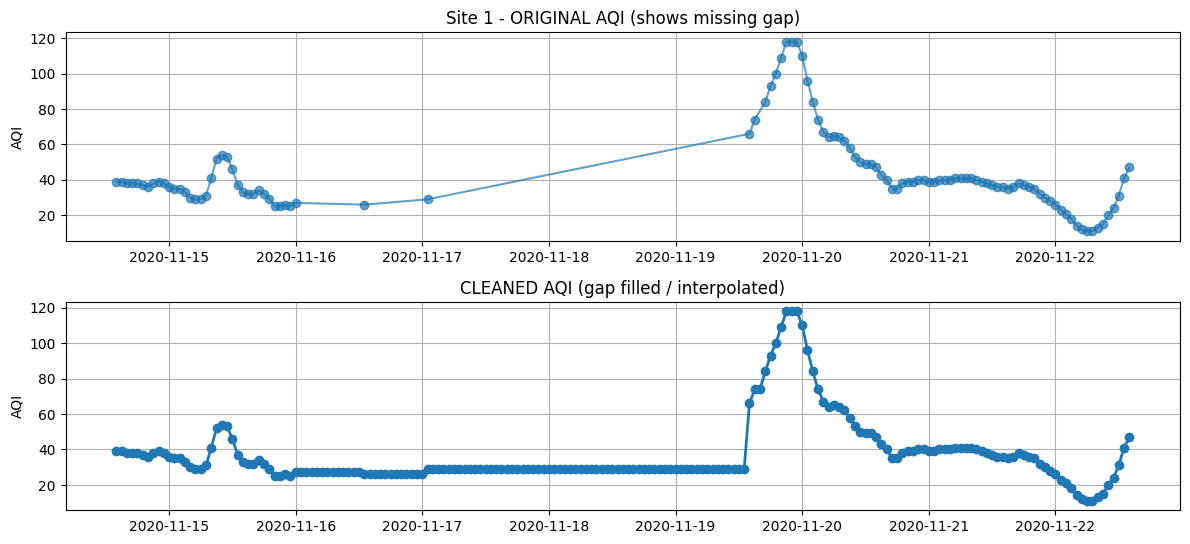

In [13]:
import matplotlib.pyplot as plt

site = 1

# Select and sort original + cleaned data for the site
df_orig_site = df[df["siteid"] == site].sort_values("date").copy()
df_clean_site = cleaned_df[cleaned_df["siteid"] == site].sort_values("date").copy()

# Compute time gaps between consecutive timestamps
df_orig_site["time_diff"] = df_orig_site["date"].diff()

# Select gaps where missing duration is between 24 and 72 hours
short_gaps = df_orig_site[
    (df_orig_site["time_diff"] > pd.Timedelta(hours=24)) &
    (df_orig_site["time_diff"] <= pd.Timedelta(hours=72))
]

short_gaps.head()   # shows where short gaps exist

# If a short gap exists, select a window around it
if not short_gaps.empty:
    gap_time = short_gaps.iloc[0]["date"]   # the timestamp after the missing gap
    start_time = gap_time - pd.Timedelta(hours=120)
    end_time   = gap_time + pd.Timedelta(hours=72)

    # Extract the window from original data
    orig_window  = df_orig_site[
        (df_orig_site["date"] >= start_time) &
        (df_orig_site["date"] <= end_time)
    ]

    # Extract the same window from cleaned data
    clean_window = df_clean_site[
        (df_clean_site["date"] >= start_time) &
        (df_clean_site["date"] <= end_time)
    ]
else:
    print("No short gaps (1–3 hours) found for this site.")

plt.figure(figsize=(12, 8))

# ---------------------------------------
# Plot 1: Original data (shows raw gap)
# ---------------------------------------
plt.subplot(3, 1, 1)
plt.plot(orig_window["date"], orig_window["aqi"], marker="o", alpha=0.7)
plt.title(f"Site {site} - ORIGINAL AQI (shows missing gap)")
plt.ylabel("AQI")
plt.grid(True)

# ---------------------------------------
# Plot 2: Cleaned data (gap filled)
# ---------------------------------------
plt.subplot(3, 1, 2)
plt.plot(clean_window["date"], clean_window["aqi"], marker="o", linewidth=2)
plt.title("CLEANED AQI (gap filled / interpolated)")
plt.ylabel("AQI")
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
# Save to google Drive
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/USD/2025 Fall/AAI-501/Final Project/datasets/'
cleaned_df.sort_values(by=['siteid', 'date'], inplace=True)
cleaned_df.to_csv(path + 'cleaned_df.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.5 Exploratory Data Analysis

In [2]:
try:
    cleaned_df
    print("cleaned_df already loaded.")
except NameError:
    from google.colab import drive
    drive.mount('/content/drive')
    path = google_drive_path

    cleaned_df = pd.read_csv(path + 'cleaned_df.csv')
    cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])

    for col in cleaned_df.columns:
        if col not in ['date', 'sitename', 'county', 'pollutant', 'status', 'unit']:
            cleaned_df[col] = pd.to_numeric(cleaned_df[col], errors='coerce')

    print("cleaned_df loaded.")

Mounted at /content/drive
cleaned_df loaded.


In [3]:
keep_cols = ['siteid', 'date', 'status', 'so2', 'co', 'o3', 'pm10', 'pm2.5', 'no2', 'nox', 'no', 'windspeed', 'winddirec', 'aqi']
pollutants = ['pm2.5', 'pm10', 'o3', 'no2', 'nox', 'no', 'so2', 'co']
feature_df = cleaned_df[keep_cols]

#### 1.5.1 Feature Correlations

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

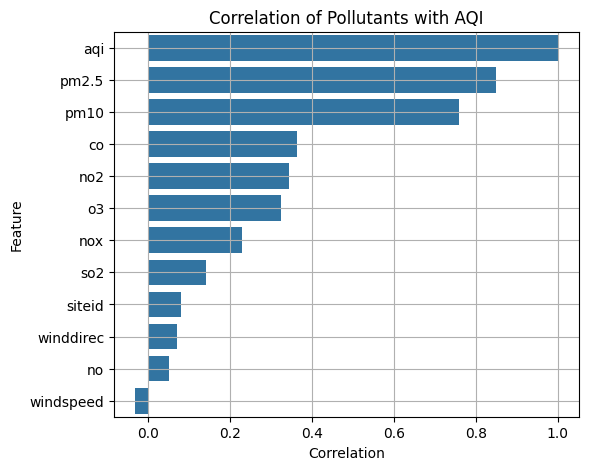

In [16]:
# Compute correlations with AQI only
corr_with_aqi = feature_df.corr(numeric_only=True)["aqi"].sort_values(ascending=False)

plt.figure(figsize=(6, 5))
sns.barplot(x=corr_with_aqi.values, y=corr_with_aqi.index)
plt.title("Correlation of Pollutants with AQI")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

### 1.5.2 ECDF of Pollutants: Normal vs Abnormal AQI

/tmp/ipython-input-2250060706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df['is_abnormal'] = feature_df['status'].isin([
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


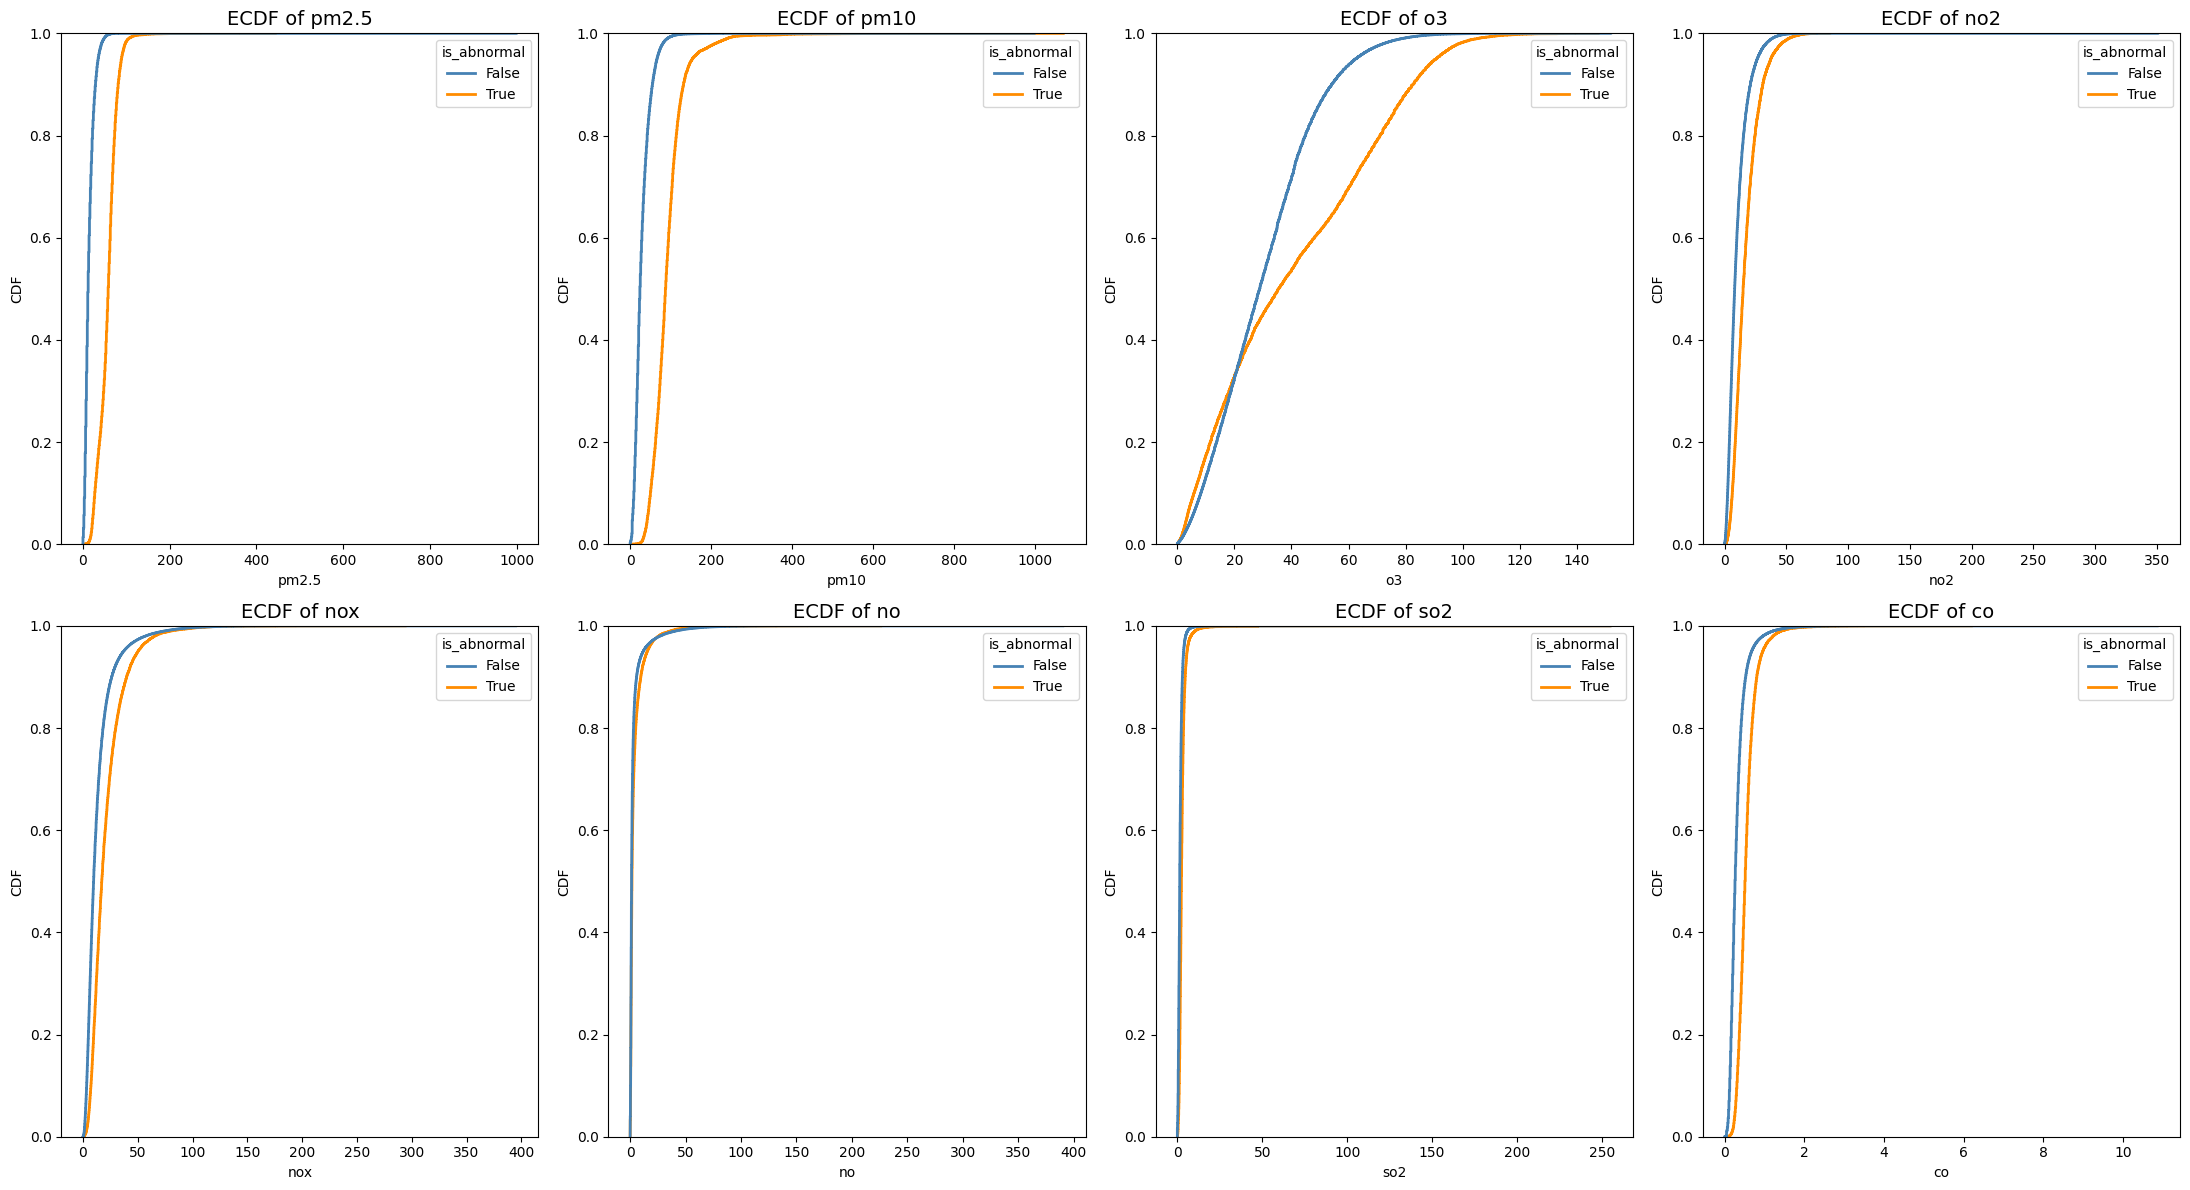

In [30]:
feature_df['is_abnormal'] = feature_df['status'].isin([
    'Unhealthy', 'Very Unhealthy', 'Hazardous'
])

plt.figure(figsize=(22, 12))

for i, col in enumerate(pollutants):
    plt.subplot(2, 4, i + 1)

    # filter out negative values
    df_clean = feature_df[feature_df[col] >= 0]

    # draw ECDF
    sns.ecdfplot(
        data=df_clean,
        x=col,
        hue='is_abnormal',
        palette={False: 'steelblue', True: 'darkorange'},
        linewidth=2
    )

    plt.title(f"ECDF of {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("CDF")

plt.tight_layout()
plt.show()


Interpretation of ECDF Plots

The ECDF plots show a clear separation between normal (Good/Moderate) and abnormal (Unhealthy/Very Unhealthy/Hazardous) AQI conditions for most pollutants.
In general:

*   PM2.5, PM10, NO, NO₂, and NOₓ have ECDF curves that shift strongly to the right under abnormal AQI conditions, indicating significantly higher concentrations.
*   O₃ and CO exhibit a mild rightward shift, suggesting smaller but still noticeable differences
*   SO₂ shows the smallest difference.

These results indicate that PM2.5, PM10, CO, NO₂ and NOx pollutants are the dominant contributors to abnormal AQI conditions.

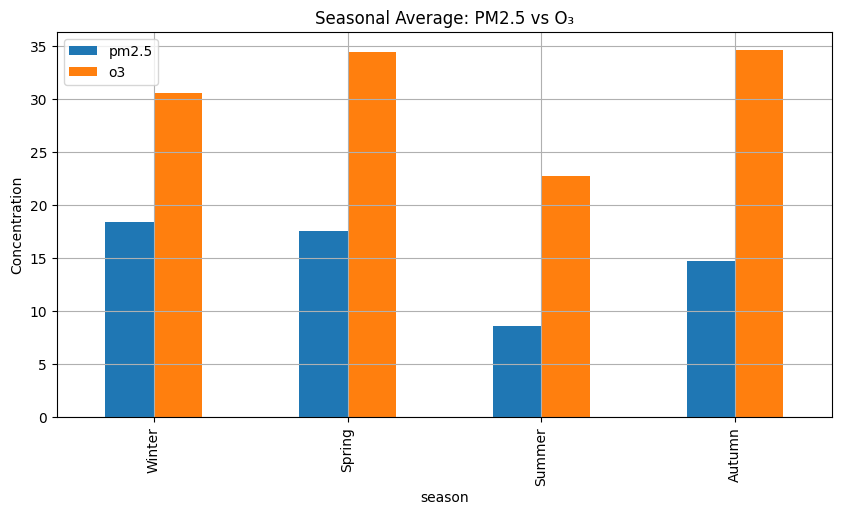

In [33]:
# Seasonal difference (PM2.5 vs O₃)
feature_df.loc[:, "month"] = feature_df["date"].dt.month

# Simple season mapping for Taiwan
def get_season(m):
    if m in [12, 1, 2]:
        return "Winter"
    if m in [3, 4, 5]:
        return "Spring"
    if m in [6, 7, 8]:
        return "Summer"
    return "Autumn"

feature_df.loc[:, "season"] = feature_df["month"].apply(get_season)

season_avg = feature_df.groupby("season")[["pm2.5", "o3"]].mean().reindex(
    ["Winter", "Spring", "Summer", "Autumn"]
)

season_avg.plot(kind="bar", figsize=(10,5))
plt.title("Seasonal Average: PM2.5 vs O₃")
plt.ylabel("Concentration")
plt.grid(True)
plt.show()

## 1.6 Features Engineering

### 1.6.1 Time Features

In [4]:
df_features = feature_df.copy()

# Basic time features
df_features["hour"] = df_features["date"].dt.hour
df_features["day"] = df_features["date"].dt.day
df_features["weekday"] = df_features["date"].dt.weekday   # Monday=0
df_features["month"] = df_features["date"].dt.month

# Seasonal flags
df_features["is_weekend"] = df_features["weekday"].isin([5, 6]).astype(int)

# Cyclic time features
df_features["hour_sin"] = np.sin(2 * np.pi * df_features["hour"] / 24)
df_features["hour_cos"] = np.cos(2 * np.pi * df_features["hour"] / 24)

df_features["month_sin"] = np.sin(2 * np.pi * df_features["month"] / 12)
df_features["month_cos"] = np.cos(2 * np.pi * df_features["month"] / 12)

### 1.6.2  Lag Features

In [5]:
# Lag Features
lag_hours = [1, 6, 24]

for lag in lag_hours:
    df_features[f"aqi_lag_{lag}"] = df_features["aqi"].shift(lag)
    df_features[f"pm25_lag_{lag}"] = df_features["pm2.5"].shift(lag)
    df_features[f"co_lag_{lag}"] = df_features["co"].shift(lag)
    df_features[f"o3_lag_{lag}"] = df_features["o3"].shift(lag)
    df_features[f"no2_lag_{lag}"] = df_features["no2"].shift(lag)

###1.6.3 Rolling Window Statistics

In [6]:
windows = [8, 24]

for w in windows:
    df_features[f"aqi_rollmean_{w}"] = df_features["aqi"].rolling(w).mean()
    df_features[f"aqi_rollstd_{w}"] = df_features["aqi"].rolling(w).std()

    df_features[f"pm25_rollmean_{w}"] = df_features["pm2.5"].rolling(w).mean()
    df_features[f"pm25_rollstd_{w}"] = df_features["pm2.5"].rolling(w).std()

    df_features[f"co_rollmean_{w}"] = df_features["co"].rolling(w).mean()
    df_features[f"co_rollstd_{w}"] = df_features["co"].rolling(w).std()

    df_features[f"o3_rollmean_{w}"] = df_features["o3"].rolling(w).mean()
    df_features[f"o3_rollstd_{w}"] = df_features["o3"].rolling(w).std()

    df_features[f"no2_rollmean_{w}"] = df_features["no2"].rolling(w).mean()
    df_features[f"no2_rollstd_{w}"] = df_features["no2"].rolling(w).std()

In [ ]:
df_features.dropna(inplace=True)
df_features.reset_index(drop=True, inplace=True)
df_features.head()